## Custom implementation of *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [6]:
import numpy as np
import itertools

from qiskit.visualization import plot_histogram
from qiskit import Aer, transpile, QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.standard_gates import RYGate

In [7]:
random_matrix=np.random.rand(3, 3) 
example_matrix=np.dot(random_matrix, random_matrix.T)

eig, e_v = np.linalg.eig(example_matrix)

# choose eigenvalues for the matrix
b = np.array([2, 3, 1])

example_matrix = e_v @ np.diag(b) @ e_v.T

paper_example_matrix = np.array([[1.5, 0.5],[0.5, 1.5]])
# example_matrix = paper_example_matrix

print(f'Matrix: {example_matrix.round(2)}\n')
for eigenval, eigenvec in zip(np.linalg.eig(example_matrix)[0][::-1], np.rot90(np.linalg.eig(example_matrix)[1])):
    print(f'eigenvalue: {eigenval:.0f} - eigenvector: {eigenvec.round(3)}')

Matrix: [[ 2.54  0.44 -0.69]
 [ 0.44  1.6   0.32]
 [-0.69  0.32  1.86]]

eigenvalue: 2 - eigenvector: [0.214 0.741 0.636]
eigenvalue: 1 - eigenvector: [-0.456  0.652 -0.606]
eigenvalue: 3 - eigenvector: [-0.864 -0.16   0.478]


as an example, we take the 2x2 matrix used in the original paper
$$
A_0=\left[\begin{array}{ll}
1.5 & 0.5 \\
0.5 & 1.5
\end{array}\right]
$$

whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

$20$ derives from $3^2 + 1^2 + 1^2 + 3^2$ and is necessary for normalization

In [8]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    sum_squares = (example_matrix**2).sum()
    input_probabilities = (example_matrix**2/sum_squares).flatten()

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]

    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

In [9]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

0 -> 0.8674858806767364
1 -> 0.4974618043895501
00 -> 0.7219066910588735
01 -> 0.48102233064372507
10 -> 0.4974618043895501
11 -> 0.0
000 -> 0.6882443158576778
001 -> 0.2178738907835654
010 -> 0.4361672190335952
011 -> 0.20283155478973433
100 -> 0.4974618043895501
101 -> 0.0
110 -> 0.0
111 -> 0.0
0000 -> 0.6783166278700701
0001 -> 0.11647656702264059
0010 -> 0.18412561369833721
0011 -> 0.11647656702264056
0100 -> 0.4277890192149262
0101 -> 0.08507877525347725
0110 -> 0.18412561369833721
0111 -> 0.08507877525347725
1000 -> 0.4974618043895501
1001 -> 0.0
1010 -> 0.0
1011 -> 0.0
1100 -> 0.0
1101 -> 0.0
1110 -> 0.0
1111 -> 0.0


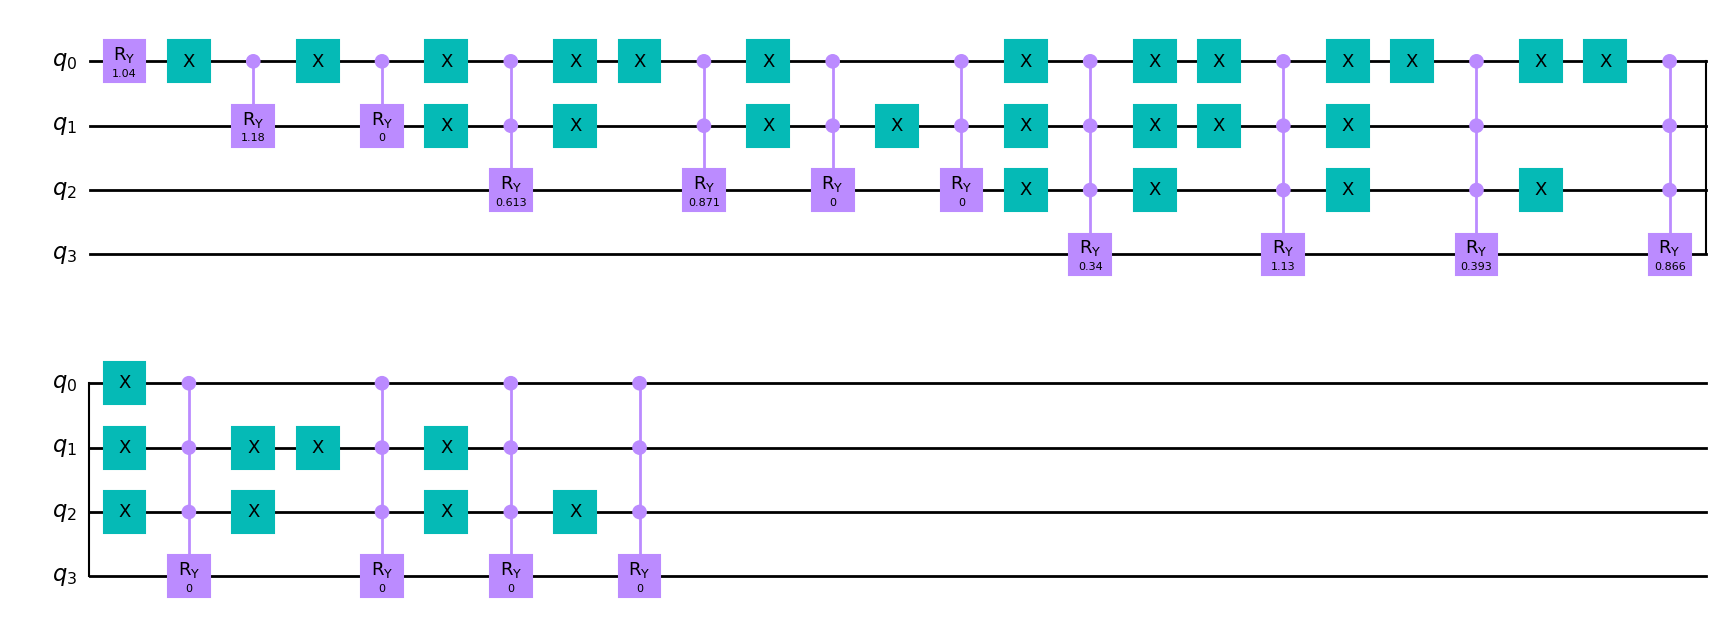

In [10]:
thetas, all_combinations = thetas_computation(example_matrix)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw("mpl")

In [12]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

{'0000': 0.460113447645022,
 '0001': 0.247468246826507,
 '0010': 0.183003444960868,
 '0100': 0.033902241619789,
 '0110': 0.033902241619789,
 '1000': 0.01356679066538,
 '1010': 0.007238397998632,
 '1100': 0.01356679066538,
 '1110': 0.007238397998632}

### Add Phase Estimation

In [7]:
#Unitary for PE
resolution = 2

unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

C:\Users\emanu\AppData\Local\Temp\ipykernel_17148\152992551.py:5: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))


Operator([[-0.5+0.5j, -0.5-0.5j],
          [-0.5-0.5j, -0.5+0.5j]],
         input_dims=(2,), output_dims=(2,))

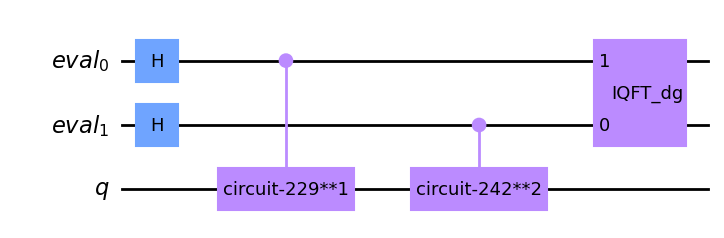

In [8]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

### Check Statevector

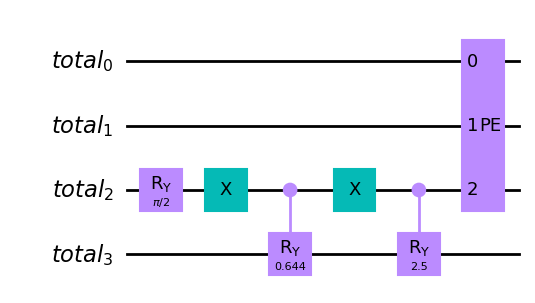

In [9]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])

total_circuit.decompose(reps=1).draw("mpl")

In [10]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [11]:
def attach_bitstrings(vector):
    return zip(bitstrings, vector)

bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix))))]
ss=attach_bitstrings(statevector)

real_statevector_dictionary = {}
for el in ss:
    real_statevector_dictionary[el[0]]=el[1]

{key : np.real(real_statevector_dictionary[key]) for key in real_statevector_dictionary.keys() if real_statevector_dictionary[key] != 0.0}


{'0001': 0.4472,
 '0010': 0.2236,
 '0101': 0.4472,
 '0110': -0.2236,
 '1001': 0.4472,
 '1010': -0.2236,
 '1101': 0.4472,
 '1110': 0.2236}

### Computing Probabilities

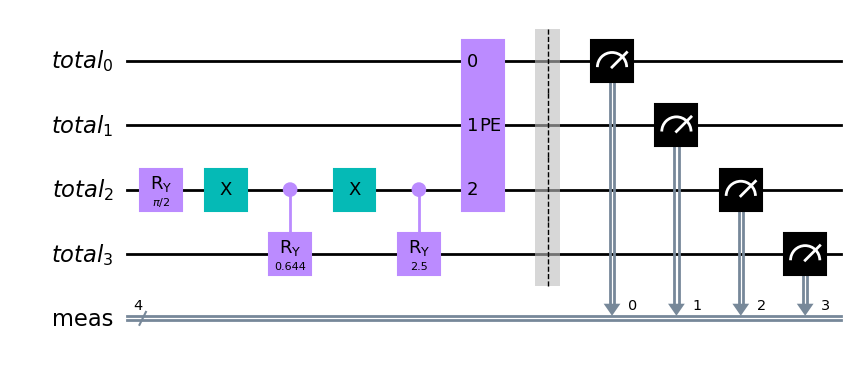

In [12]:
total_circuit_measured = QuantumCircuit(qr_total , name='matrix')

total_circuit_measured.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit_measured.append(pe.to_gate(), qr_total[0:pe.num_qubits])

total_circuit_measured.measure_all()

total_circuit_measured.decompose(reps=1).draw("mpl")

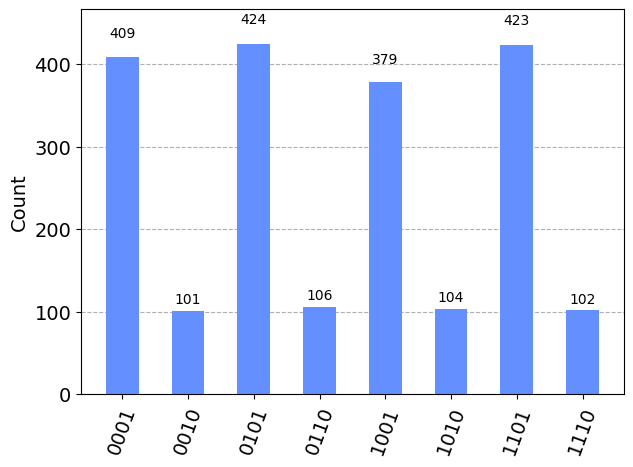

In [13]:
n_shots = 2048
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_measured, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

### Storing probabilities

In [14]:
for i in counts:
    counts[i]/=n_shots
# print(counts)

statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
# statevector

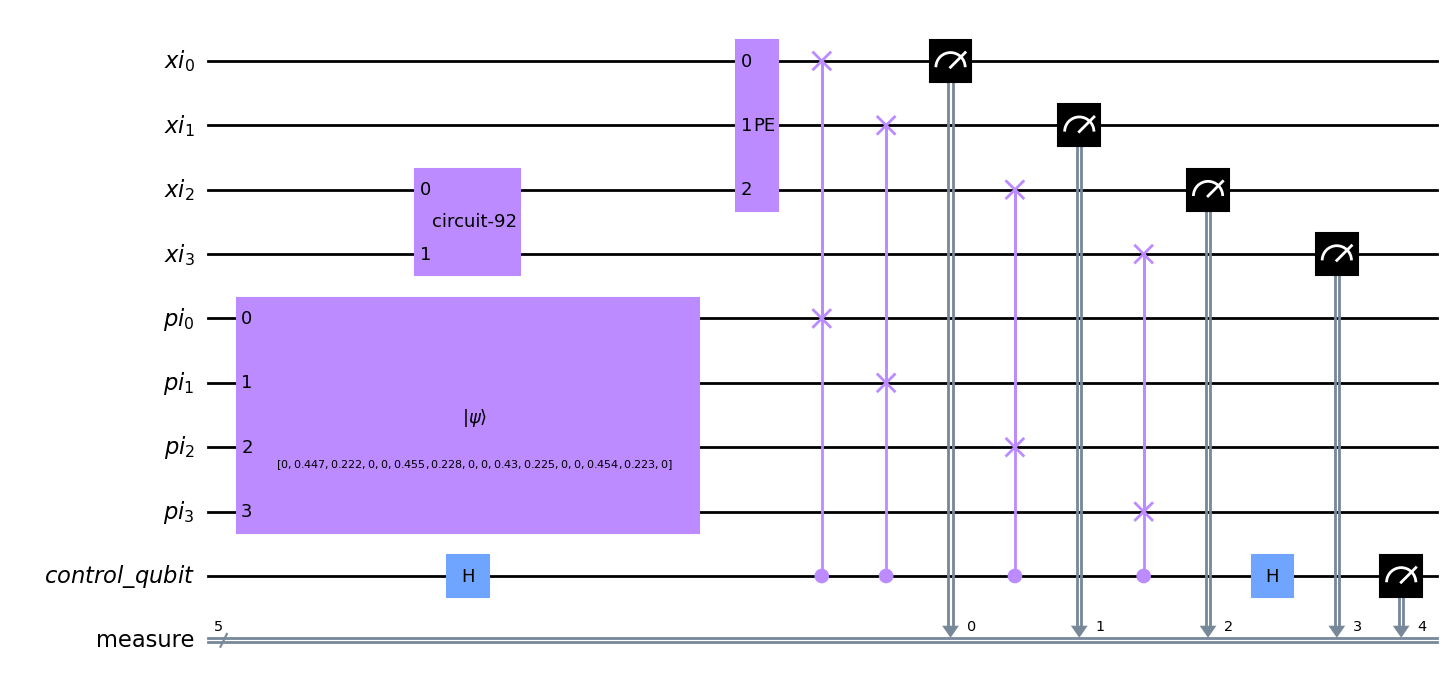

In [15]:
qr_total_xi = QuantumRegister(tot_qubit, 'xi')
qr_total_pi = QuantumRegister(tot_qubit, 'pi')
qr_control = QuantumRegister(1, 'control_qubit')
n_classical_register=tot_qubit+1
classical = ClassicalRegister(n_classical_register, 'measure')

total_circuit_tomography = QuantumCircuit(qr_total_xi,qr_total_pi,qr_control ,classical, name='matrix')

total_circuit_tomography.append(matrix_circuit.to_gate(), qr_total_xi[resolution:])
total_circuit_tomography.append(pe.to_gate(), qr_total_xi[0:pe.num_qubits])

#total_circuit_2.swap(qr_total_xi[0],qr_total_xi[1])
total_circuit_tomography.initialize(np.sqrt(statevector),qr_total_pi)
total_circuit_tomography.h(qr_control)
for i in range(tot_qubit):
    total_circuit_tomography.cswap(control_qubit=qr_control, target_qubit1=qr_total_xi[i],target_qubit2=qr_total_pi[i])

total_circuit_tomography.h(qr_control)
total_circuit_tomography.measure(qr_total_xi,classical[0:n_classical_register-1])
total_circuit_tomography.measure(qr_control,classical[n_classical_register-1])

total_circuit_tomography.draw("mpl")

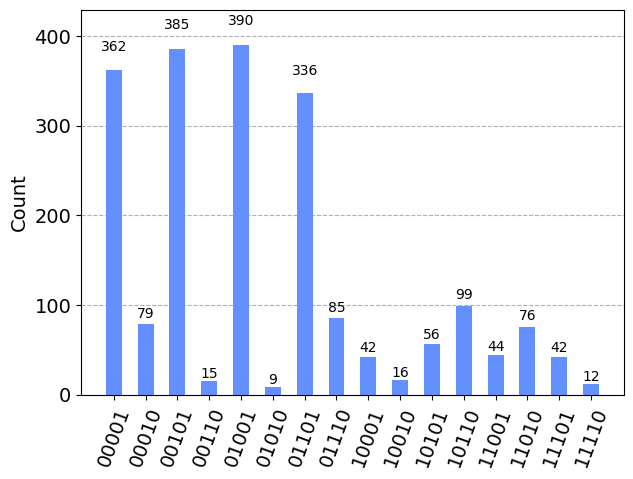

In [16]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_tomography, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [17]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
# tmp
# statevector

In [18]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=0
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

# sign_dictionary

In [19]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

{key : round(statevector_dictionary[key], 4) for key in statevector_dictionary.keys() if statevector_dictionary[key] != 0.0}

{'0001': 0.4469,
 '0010': 0.2221,
 '0101': 0.455,
 '0110': -0.2275,
 '1001': 0.4302,
 '1010': -0.2253,
 '1101': 0.4545,
 '1110': 0.2232}

## Eigenvectors Reconstruction (Generalized)

In [20]:
# statevector_dictionary = real_statevector_dictionary
binary_lambda=[]
for d in statevector_dictionary:
    if statevector_dictionary[d]!=0:
        binary_lambda.append(d[-resolution:])
l_list=[]
eigenvalues=[]
for b_l in np.unique(binary_lambda):
    eigenvalues.append(int(b_l[::-1],2))
    tmp_list=[]
    for key in list(statevector_dictionary.keys()):
        if key[-resolution:]==b_l:
            tmp_list.append(statevector_dictionary[key])
    l_list.append(np.asarray(tmp_list))

for l in l_list:
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor

In [21]:
print("Quantum method results:")
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(l_list,eigenvalues):
    #print(ll,eig)
    # eigenvector=np.zeros(len(example_matrix)) #put length of eigenvector
    save_sign=np.sign(ll)
    statevector=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(statevector),len(example_matrix))):
        max_list.append(max(statevector[i:i+len(example_matrix)]))
        scaled_statevectors.append(statevector[i:i+len(example_matrix)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvectors.append(eigenvector)
    # print(eigenvector)
    print(f'eigenvalue: {eig} - eigenvector: {np.real(eigenvector.round(3))}')    

Quantum method results:
eigenvalue: 2 - eigenvector: [0.701 0.714]
eigenvalue: 1 - eigenvector: [ 0.695 -0.712]


In [22]:
print("Classically computed values:")
for eigenval, eigenvec in zip(np.linalg.eig(example_matrix)[0][::-1], np.rot90(np.linalg.eig(example_matrix)[1])):
    print(f'eigenvalue: {eigenval:.0f} - eigenvector: {eigenvec.round(3)}')
# np.linalg.eig(example_matrix)

Classically computed values:
eigenvalue: 1 - eigenvector: [-0.707  0.707]
eigenvalue: 2 - eigenvector: [0.707 0.707]


Nota: l'autovettore di una matrice è un vettore che mantiene la sua direzione quando viene trasformato dalla matrice. Moltiplicare ogni componente dell'autovettore per -1 inverte solo la direzione del vettore, ma mantiene la sua relazione con la trasformazione data dalla matrice. Pertanto, un autovettore moltiplicato per -1 resta ancora un autovettore della stessa matrice.

Nota 2 (soglia): è possibile conoscere la somma degli autovalori di una matrice senza calcolare gli autovalori. Un modo per farlo è usare la traccia della matrice, che è definita come la somma degli elementi della diagonale della matrice. La traccia di una matrice è uguale alla somma dei suoi autovalori.